In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D, concatenate, add
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import json
from datetime import datetime
import PIL.Image
import sys
from PIL import Image
sys.modules['Image'] = Image
import io
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange

In [3]:
if False:
    from google.colab import drive
    drive.mount('/content/drive')

# hyperparameters, constants and paths
You can either set them in the dictionary here or in an external json file.

In [26]:
#name of the network (used to create directories for logs)
my_name = 'unet_4'
        
#paths
cwd = os.getcwd()
base_dir = cwd            #if using Colab: '/content/drive/My Drive/an2dl_hw2'
data_dir =  os.path.join(base_dir, 'Development_Dataset', 'Training', 'Weedelec')

train_dir = os.path.join(data_dir, 'cutted_2_3_512')   #where the tiles (images and masks are placed)
train_images_dir = os.path.join(train_dir, 'Images')
train_masks_dir = os.path.join(train_dir, 'Masks')
split_dir = os.path.join(train_dir, 'Splits')
train_split_file = os.path.join(split_dir, 'train.txt')       
valid_split_file = os.path.join(split_dir, 'val.txt')
test_dir = os.path.join(base_dir, 'Development_Dataset', 'Test_Dev', 'Weedelec')

#folders for logs and ckpts
exps_dir = os.path.join(base_dir, 'exps_2')


#number of crop folders and their path to Images & Masks
#We chose to learn the class of different crops separately 
#and put them together only in the prediction output
ncrop=2      #number of crop considered (haricot and mais).
internal_classes = ncrop + 2        #a class for each crop plus background and weed
num_classes = 3             #these are the ouput classes of the prediction: background: 0, crop: 1, weed: 2

#paths to crop folders
images_dir=[]
masks_dir=[]
crop_names=[]
white_to=[]
#Where to save tiles
cut_images_dir = os.path.join(base_dir, 'Development_Dataset', 'Training', 'Weedelec')
#MAIS
crop_names.append('Mais')
white_to.append((255,255,255))
mais_original_images_dir = os.path.join(data_dir, 'Mais')
images_dir.append(os.path.join(mais_original_images_dir, 'Images'))
masks_dir.append(os.path.join(mais_original_images_dir, 'Masks'))
#HARICOT
crop_names.append('Haricot')
white_to.append((0,0,255))
haricot_original_images_dir = os.path.join(data_dir, 'Haricot')
images_dir.append(os.path.join(haricot_original_images_dir, 'Images'))
masks_dir.append(os.path.join(haricot_original_images_dir, 'Masks'))


#if true, it will load the hyperparameters from json
load_hyp_json = False
hyp_json_path = os.path.join(base_dir, 'hyp_config.json') 

if load_hyp_json:
    with open(hyp_json_path)as json_hyp:
        hyp_config = json.load(json_hyp)
else:
    hyp_config = {
        "SEED": 1234,
        "bs": 2,
        "train_split": 0.8,
        "img_w": 512,
        "img_h": 512,
        "apply_data_augmentation": True,
        "lr": 1e-4,
        "dropout_factor": 0.0, 
        "create_cm": False,
        "tile_pr": 3,
        "tile_rw": 2
    }


# Set the seed for random operations. 
# This let our experiments to be reproducible.
SEED = hyp_config["SEED"]
tf.random.set_seed(SEED)
random.seed(SEED)

#batch size
bs = hyp_config["bs"] 

#percentage of images used for training
train_split = hyp_config["train_split"]

#img shape
img_w = hyp_config["img_w"]
img_h = hyp_config["img_h"]

#if true, data augmentation will be applied
apply_data_augmentation = hyp_config["apply_data_augmentation"]
#learning rate
lr = hyp_config["lr"]

#dropout
dropout_factor = hyp_config["dropout_factor"]

#create_cm = hyp_config["create_cm"]

#numebr of tiles per row
tile_pr = hyp_config["tile_pr"]
#number of rows of tiles
tile_rw = hyp_config["tile_rw"]

#compute the number of tiles and the size of the downsampled image
#(the image is first downsampled a bit and the tiled)
xres = tile_pr*img_w
yres = tile_rw*img_h
numtile = tile_pr*tile_rw

In [27]:
hyp_config

{'SEED': 1234,
 'bs': 2,
 'train_split': 0.8,
 'img_w': 512,
 'img_h': 512,
 'apply_data_augmentation': True,
 'lr': 1e-06,
 'dropout_factor': 0.0,
 'create_cm': False,
 'tile_pr': 3,
 'tile_rw': 2}

# Preprocessing
## Tiling

In [6]:
# the images of the dataset(s) choosen are resized to an intermediate resolution and then tiled. 
# The tiles are saved on the disk to improve training performance.
if False:
    for crop in range(ncrop):

        ids=next(os.walk(images_dir[crop]))[2] # list of names all images in the given path

        for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):

            #IMAGE

            tl=0;
            tr=0;

            im = Image.open(os.path.join(images_dir[crop], id_))
            im = im.resize((xres,yres))

            id_=id_[:-4]

            for tile in range(numtile):

                box=(tl,tr,tl+img_w,tr+img_h)

                im2 = im.crop(box)
                images_cutted_dir = os.path.join(cut_images_dir, 'ImagesCutted_'+crop_names[crop])
                if not os.path.exists(images_cutted_dir):
                    os.makedirs(images_cutted_dir)
                name = id_+"_"+str(tile+1)+"of"+str(numtile)+".jpg"
                im2.save(os.path.join(images_cutted_dir, name))

                tile+=1;
                tl=tl+img_w;
                if (tile==tile_pr):
                    tl=0;
                if (tile==tile_pr):
                    tr+=img_h;

            #MASK
            im = Image.open(os.path.join(masks_dir[crop], id_+'.png'))
            im = im.resize((xres,yres), resample=Image.NEAREST)

            #recoloring
            im = im.convert('RGB')
            data = np.array(im)  
            red, green, blue = data.T 
            white_areas = (red == 255) & (blue == 255) & (green == 255)
            data[...][white_areas.T] = white_to[crop] # Transpose back needed
            im = Image.fromarray(data)

            tl=0;
            tr=0;
            tile=0;

            for tile in range(numtile):

                box=(tl,tr,tl+img_w,tr+img_h)

                im2 = im.crop(box)
                masks_cutted_dir = os.path.join(cut_images_dir, 'MasksCutted_'+crop_names[crop])
                if not os.path.exists(masks_cutted_dir):
                    os.makedirs(masks_cutted_dir)
                name = id_+"_"+str(tile+1)+"of"+str(numtile)+".png"
                im2.save(os.path.join(masks_cutted_dir, name))

                tile+=1;
                tl=tl+img_w;
                if (tile==tile_pr):
                    tl=0;
                if (tile==tile_pr):
                    tr+=img_h;

## splitting train/val

In [7]:
#this block can be used to build the train/valid lists
if False:
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)
    
    #overwrite the previous split if needed
    if os.path.exists(train_split_file):
        os.remove(train_split_file)
    if os.path.exists(valid_split_file):
        os.remove(valid_split_file)


    for filename in os.listdir(train_images_dir):
        imagename = os.path.splitext(filename)[0]
        if (random.uniform(0,1) > train_split):
            with open(valid_split_file, 'a') as file:
                file.write(imagename+'\n')
        else:
            with open(train_split_file, 'a') as file:
                file.write(imagename+'\n')                
        

# Image Segmentation
## Build dataset

In [8]:
# ImageDataGenerator
# ------------------

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=15,
                                      width_shift_range=40,
                                      height_shift_range=40,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=15,
                                       width_shift_range=40,
                                       height_shift_range=40,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

In [9]:
class CustomDataset(tf.keras.utils.Sequence):

    """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

    """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                   preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = train_split_file
        elif which_subset == 'validation':
            subset_file = valid_split_file

        with open(subset_file, 'r') as f:
            lines = f.readlines()

        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip())
            
        if which_subset == 'training':
            random.shuffle(subset_filenames)      #SHUFFLING of training dataset

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.mask_generator = mask_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
        mask = Image.open(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        # Resize image and mask
        img = img.resize(self.out_shape)
        mask = mask.resize(self.out_shape, resample=Image.NEAREST)

        mask_arr = np.array(mask)

        new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

        # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
        new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1    #mais
        new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2      #weed  
        new_mask_arr[np.where(np.all(mask_arr == [0, 0, 255], axis=-1))] = 3        #haricot

        img_arr = np.array(img)
        mask_arr = new_mask_arr

        mask_arr = np.expand_dims(mask_arr, -1)

        if self.which_subset == 'training':
            if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                NUMBER = random.randint(0,1000)
                img_t = self.img_generator.get_random_transform(img_arr.shape, seed=NUMBER)
                mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=NUMBER)
                img_arr = self.img_generator.apply_transform(img_arr, img_t)
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
                out_mask = np.zeros_like(mask_arr)
                for c in np.unique(mask_arr):
                    if c > 0:
                        curr_class_arr = np.float32(mask_arr == c)
                        curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
                        # from [0, 1] to {0, 1}
                        curr_class_arr = np.uint8(curr_class_arr)
                        # recover original class
                        curr_class_arr = curr_class_arr * c 
                        out_mask += curr_class_arr
        else:
            out_mask = mask_arr

        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)

        return img_arr, np.float32(out_mask)

In [10]:
def my_preprocess (x):
    return x/255     #the RGB values are rescaled on the range [0,1]

dataset_train = CustomDataset(train_dir, 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=my_preprocess, out_shape=[img_w, img_h])
dataset_valid = CustomDataset(train_dir, 'validation', 
                        preprocessing_function=my_preprocess, out_shape=[img_w, img_h])


In [11]:

train_dataset = tf.data.Dataset.from_generator(lambda: dataset_train,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

## Visual inspection of data generation

In [12]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, internal_classes-1)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

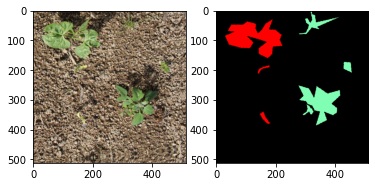

In [33]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img*255  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, internal_classes):
    target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

# Building of the model (U-net)
We readapted the structure of U-net taken from this repo: https://github.com/hlamba28/UNET-TGS

In [14]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 32, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(filters=internal_classes, 
                     kernel_size=(1, 1), 
                     strides=(1,1),
                     padding='same',                     
                     activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [19]:
input_img = Input((img_h, img_w, 3), name='img')
model = get_unet(input_img, n_filters=24, dropout=dropout_factor, batchnorm=True)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 24) 672         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 512, 512, 24) 96          conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 512, 512, 24) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

# Training
## Loss, optimizer, metrics

In [28]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 

# optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,internal_classes): # exclude the background class 0
        # Get prediction and target related to only a single class (i)
        class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
        class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
        intersection = tf.reduce_sum(class_true * class_pred)
        union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection

        iou = (intersection + 1e-7) / (union + 1e-7)
        per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Callbacks

In [29]:
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)
    
now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = my_name
exp_name = model_name + '_' + str(now)

exp_dir = os.path.join(exps_dir, exp_name)
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
#save configuration and hyperparameters
config = model.to_json()
json_model_path = os.path.join(exp_dir, 'model.json')
with open(json_model_path, 'w') as f:
    json.dump(config, f)
    
with open(os.path.join(exp_dir, 'hyp_config.json'), 'w') as f:
    json.dump(hyp_config, f)
    
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)


csv_path = os.path.join(exp_dir, 'log.csv')
log_callback = tf.keras.callbacks.CSVLogger(csv_path, append=True, separator=';')
callbacks.append(log_callback)


# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    callbacks.append(es_callback)

## Fitting the model

In [ ]:
history = model.fit(x=train_dataset,
                  epochs=100,  #### set repeat in training dataset
                  steps_per_epoch=len(dataset_train)/bs,
                  validation_data=valid_dataset,
                  validation_steps=len(dataset_valid)/bs, 
                  callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

# Classification of new samples
## Classification function
Each new input image is:
1. scaled down
2. dynamically tiled
3. each tile is classified by the network
4. the tiles are resambled back
5. crop classes are merged into a unique class
6. rescaled back to the original size

In [39]:
def classify(img, origx, origy, xres, yres, numtile, tile_pr, width, height, model):
  
    #Rescaling
    img = img.resize((xres,yres));

    #Tiling
    inputTiles=[]

    tl=0;
    tr=0;

    for tile in range(numtile):
    
        box=(tl,tr,tl+width,tr+height);

        inputTiles.append(img.crop(box));

        tile+=1;
        tl=tl+width;
        if (tile==tile_pr):
            tl=0;
        if (tile==tile_pr):
            tr+=height;

    #Classify
    classifiedTiles=[]

    for tile in range(numtile):
        out_sigmoid = model.predict(tf.expand_dims(np.array(inputTiles[tile])/255, 0));
        predicted_class = tf.argmax(out_sigmoid, -1);  # Get predicted class as the index corresponding to the maximum value in the vector probability      
        predicted_class = predicted_class[0, ...];
        classifiedTiles.append(predicted_class);
        
    #Resemble
    head=[]
    for headind in range(tile_rw):
        head.append(classifiedTiles[headind*tile_pr])

    count=0

    while (count<numtile-1):
  
        count+=1
        if count==(count//tile_pr)*tile_pr:
            count+=1
        head[count//tile_pr]=np.concatenate((head[count//tile_pr],classifiedTiles[count]),1)

    preresc=head[0]
    for col in range(1,tile_rw):
          preresc=np.concatenate((preresc,head[col]),0)

    #Deleting extra classes
    for row in range(preresc.shape[0]):
        for col in range(preresc.shape[1]):
            if preresc[row][col]>2:
                preresc[row][col]=1

    #Resize            
    rescaled=Image.fromarray(np.uint8(preresc))
    rescaled=rescaled.resize((origx,origy), resample=Image.NEAREST)
    output=np.array(rescaled)

    return output

## Test of classification
This is just for visualization purposes

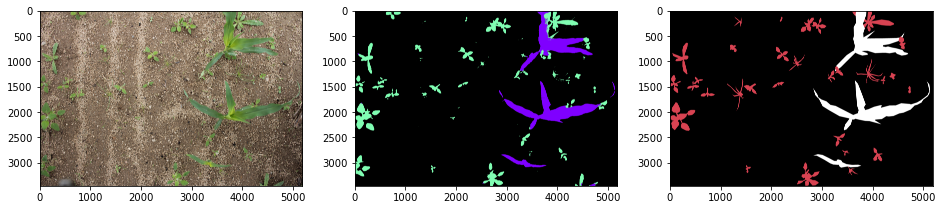

In [42]:
#test calssificator (it just works on two images taken from the validation set.)
test_img_name = 'Weedelec_haricot_2019-09-25T114516-36'
source = os.path.join(data_dir, 'Haricot')
test_img_name = 'Weedelec_mais_2019-09-25T121040-119'
source = os.path.join(data_dir, 'Mais')


test_img = Image.open(os.path.join(source, 'Images', test_img_name+'.jpg'))

fig, ax = plt.subplots(1,3, figsize=(16,16))
original = test_img
ax[0].imshow(np.uint8(original));

predicted_image = classify(img = test_img,
                           origx = 5184,
                           origy = 3456, 
                           xres = xres, 
                           yres = yres, 
                           numtile = numtile, 
                           tile_pr = tile_pr, 
                           width = img_w, 
                           height = img_h, 
                           model = model)

prediction_img = np.zeros([test_img.size[1], test_img.size[0], 3])

prediction_img[np.where(predicted_image == 0)] = [0, 0, 0]
for i in range(1, num_classes):
    prediction_img[np.where(predicted_image == i)] = np.array(colors[i-1])[:3] * 255
    
ax[1].imshow(np.uint8(prediction_img));

true_img = Image.open(os.path.join(source, 'Masks', test_img_name+'.png'))
ax[2].imshow(np.uint8(true_img));

fig.canvas.draw();

In [117]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [124]:
crops = ['Mais', 'Haricot']
teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
submission_dict = {}
for team in teams:
    for crop in crops:
        curr_dir = os.path.join(base_dir, 'Development_Dataset', 'Test_Dev', team, crop, 'Images')    
        ids=next(os.walk(curr_dir))[2]    
        #fig, ax = plt.subplots(len(ids), 2, figsize=(64,64))
        for i, full_img_name in enumerate(ids):
            img_name = full_img_name[:-4]
            curr_img = Image.open(os.path.join(curr_dir, full_img_name))

            predicted_img = classify(img = curr_img,
                               origx = curr_img.size[0],
                               origy = curr_img.size[1], 
                               xres = xres, 
                               yres = yres, 
                               numtile = numtile, 
                               tile_pr = tile_pr, 
                               width = img_w, 
                               height = img_h, 
                               model = model)

            submission_dict[img_name] = {}
            submission_dict[img_name]['shape'] = predicted_img.shape
            submission_dict[img_name]['team'] = team
            submission_dict[img_name]['crop'] = crop
            submission_dict[img_name]['segmentation'] = {}

            # RLE encoding
            # crop
            rle_encoded_crop = rle_encode(predicted_img == 1)
            # weed
            rle_encoded_weed = rle_encode(predicted_img == 2)

            submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
            submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

            #ax[i, 0].imshow(np.uint8(curr_img))
            #ax[i, 1].imshow(np.uint8(predicted_img))

        #fig.canvas.draw()
    
with open(os.path.join(base_dir, 'predictions', exp_name+'.json'), 'w') as f:
    json.dump(submission_dict, f)
        

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512

 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 3 3 ... 1 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 3 0 ... 1 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 0]
 [3 3 3 ... 3 3 0]
 [0 3 3 ... 3 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512

 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1536)
<class 'numpy.ndarray'>
<class 'numpy.int64'>
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [45]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

C:\Users\Michele\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


(1, 512, 512, 4)

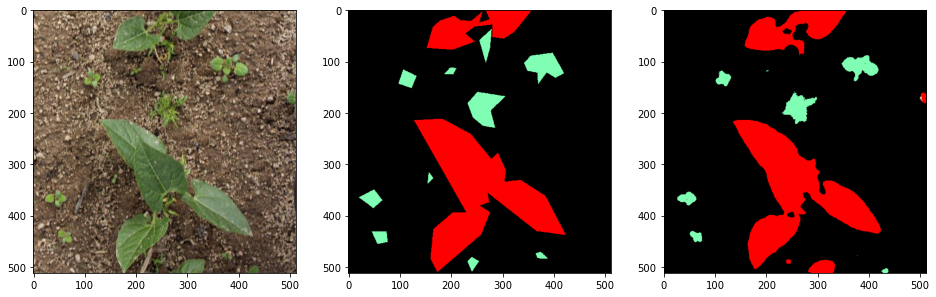

In [79]:
    fig, ax = plt.subplots(1, 3, figsize=(16, 16))
    fig.show()

    image, target = next(iterator)
    print()

    image = image[0]
    target = target[0, ..., 0]

    out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
    # predicted_class = predicted_class[0, ..., 0]
    #out_sigmoid = out_sigmoid[:,:,:,1:2]
    predicted_class = tf.argmax(out_sigmoid, -1)

    out_sigmoid.shape

    predicted_class = predicted_class[0, ...]

    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

    target_img[np.where(target == 0)] = [0, 0, 0]
    for i in range(1, internal_classes):
        target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

        prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
        prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

    ax[0].imshow(np.uint8(image*255))
    ax[1].imshow(np.uint8(target_img))
    ax[2].imshow(np.uint8(prediction_img))

    fig.canvas.draw()
    time.sleep(1)
    